In [268]:
from numpy import linalg as LA
import rasterio
import numpy as np
import skimage as sk
from skimage.transform import resize
import matplotlib.pyplot as plt


In [269]:
#numero de columnas y filas
nc=720
nr=720
n=nc*nr
#indice normalizado de diferencia de vegetación
indv=[]
#fecha inicial y final
fechai=1994
fechaf=2011
#repeticiones entre fechas
rep=2011-1994
#dif
fevar= (fechaf-fechai+1)
var= int((fechaf-fechai+1)/(rep-1))
for i in range(0,int(fevar),rep):
    fecha=fechai+i
    car=str(fecha)
    print(car)
    ruta="/home/noxd/Home2/hermosillo/data/im" + car +".tif"
    data1=rasterio.open(ruta)
    r = data1.read((3)) 
    nir= data1.read((4)) 
    i_gray = sk.color.rgb2gray((nir-r)/(r+nir))
    i_grayr=resize(i_gray, (nr, nc))
    equalizada = sk.exposure.equalize_hist(i_grayr)
    indv.append( equalizada   )

1994
2011


In [271]:
dindv=[]
for u in range(0,len(indv)-1):
    dindv.append(abs(indv[u+1]-indv[u]))

In [272]:
def PCA(dindv,block,indice):
    #contador
    M=0
    bloque_medio= np.zeros(shape=(block*block,1))
    for r in range(0,nr,block):
        for t in range(0,nc,block):
            bloque_medio=bloque_medio+dindv[indice][r:r+block,t:t+block].reshape(block*block,1)
            #print(r,t)
            M=M+1
    bloque_medio=bloque_medio/M
    cov= np.zeros(shape=(block*block,block*block))
    for r in range(0,nr,block):
        for t in range(0,nc,block):
            cov=cov+  np.matmul(    dindv[indice][r:r+block,t:t+block].reshape(block*block,1)-bloque_medio, dindv[indice][r:r+block,t:t+block].reshape(block*block,1).T-bloque_medio.T)
    cov=cov/M
    evalues,evector =LA.eig(cov)
    order = evalues.argsort()[::-1]
    evalues1 = evalues[order]
    evector1 = evector[:,evalues.argsort()[::-1]]
    ev=np.zeros(shape=(block*block,block*block))
    for l in range(0,block*block):
        ev.T[0:block*block,l:l+1]= (1/np.sqrt((evalues1[l])*block*block))*evector1.T[0:block*block,l:l+1]  
    return ev,evalues1,bloque_medio

In [291]:
block=5
indice=0
ev,evalues1,bloque_medio= PCA(dindv,block,0)


Text(0.5, 1.0, 'Información "retenida" en los componentes principales para bloque de tamaño 3')

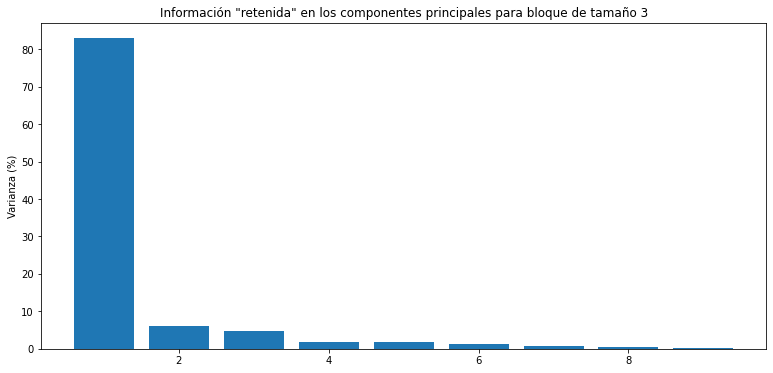

In [283]:
lista1=[]
lista2=[]
for i in range(0,block*block):
    lista1.append(i+1)
    lista2.append('PC' + str(i+1))
    
plt.figure(figsize=(13,6))
plt.bar(lista1,evalues1/sum(evalues1)*100,align='center')
plt.ylabel('Varianza (%)')
plt.title('Información "retenida" en los componentes principales para bloque de tamaño '+ str(block))

Text(0.5, 1.0, 'Información "retenida" en los componentes principales para bloque de tamaño 5')

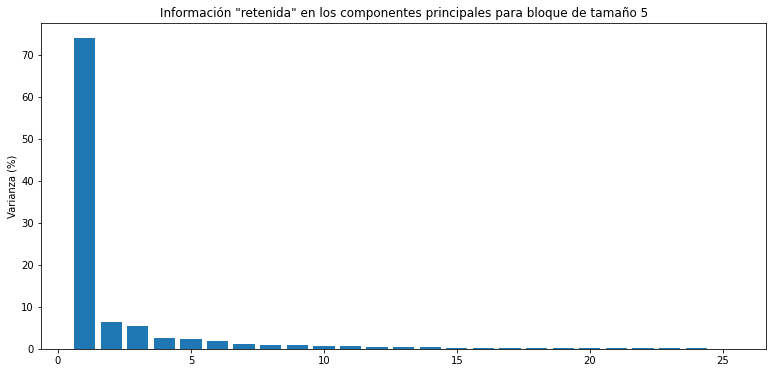

In [292]:
lista1=[]
lista2=[]
for i in range(0,block*block):
    lista1.append(i+1)
    lista2.append('PC' + str(i+1))
    
plt.figure(figsize=(13,6))
plt.bar(lista1,evalues1/sum(evalues1)*100,align='center')
plt.ylabel('Varianza (%)')
plt.title('Información "retenida" en los componentes principales para bloque de tamaño '+ str(block))

Text(0.5, 1.0, 'Información "retenida" en los componentes principales para bloque de tamaño 9')

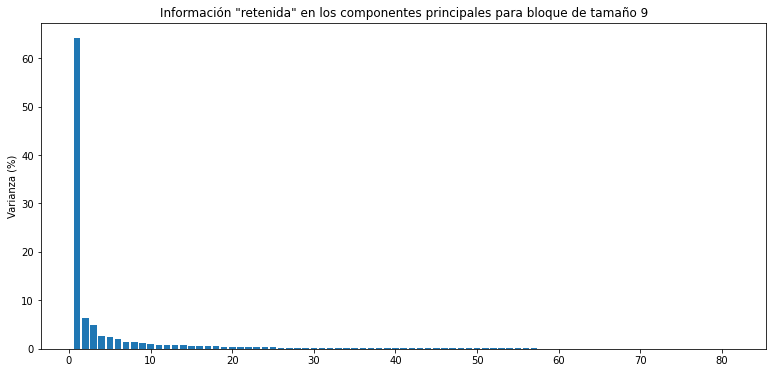

In [260]:
lista1=[]
lista2=[]
for i in range(0,block*block):
    lista1.append(i+1)
    lista2.append('PC' + str(i+1))
    
plt.figure(figsize=(13,6))
plt.bar(lista1,evalues1/sum(evalues1)*100,align='center')
plt.ylabel('Varianza (%)')
plt.title('Información "retenida" en los componentes principales para bloque de tamaño '+ str(block))

In [277]:
def kmeans(dindv,indice,block, S,bloque_medio): 
    feature_vector={}
    for r in range(0,nr):
        for t in range(0,nc):
                fv_pixel=dindv[indice][int(r-block/2):int(r+block/2),int(t-block/2):int(t+block/2)]
                if fv_pixel.shape[0]*fv_pixel.shape[1] ==block*block: 
                    fv=np.matmul(ev.T[0:S,0:block*block]   , fv_pixel.reshape(block*block,1)-bloque_medio)
                    feature_vector.update( {str(int(r))+str(int(t)): fv} )
    clase1=[]
    clase2=[]
    media1= np.random.rand(S,1)
    media2= np.random.rand(S,1)
    error1=1
    error2=1
    iterador=0
    while error1>0.0001 and error2>0.0001:
        for r in range(0,nr,block):
            for t in range(0,nc,block):
                fv_pixel=dindv[indice][int(r-block/2):int(r+block/2),int(t-block/2):int(t+block/2)]
                if fv_pixel.shape[0]*fv_pixel.shape[1] ==block*block: 
                    fv=feature_vector[str(int(r))+str(int(t))]
                    norm1=( np.linalg.norm(fv-media1)    )
                    norm2=( np.linalg.norm(fv-media2)    )
                    if norm1<norm2:
                        clase1.append(fv)
                    elif norm2<norm1:
                        clase2.append(fv)
                    else:
                        flip=np.random.randint(2)
                        if flip==0:
                            clase1.append(fv)
                        else:
                            clase2.append(fv)
        media_anterior1=media1
        media_anterior2=media2
        media1=0
        media2=0
        for e in range(0,len(clase1)):
            media1=media1+clase1[e]
        media1=media1/len(clase1)
        for z in range(0,len(clase2)):
            media2=media2+clase2[z]
        media2=media2/len(clase2)
        error1=np.linalg.norm(media1-media_anterior1)
        error2=np.linalg.norm(media2-media_anterior2)
        clase1=[]
        clase2=[]
        iterador=iterador+1
    print('Se logro convergencia en', iterador, 'iteraciones')
    prom_media1= np.linalg.norm(media1)
    prom_media2=np.linalg.norm(media2)
    if (prom_media1<prom_media2):
        m1=media1
        m2=media2
        media1=m1
        media2=m2
    elif prom_media2<prom_media1:
        m1=media2
        m2=media1
        media1=m1
        media2=m2   
    else:
        print('Las clases no son diferenciables (tienen la misma media)')
    return media1, media2

In [293]:
ev.shape

(25, 25)

In [294]:
S=15
media1, media2= kmeans(dindv,indice,block, S,bloque_medio)

Se logro convergencia en 18 iteraciones


In [279]:
def mapeo(dindv, indice, block,media1, media2,bloque_medio):
    cambio= np.zeros(shape=dindv[indice].shape)
    for r in range(0,nr):
        for t in range(0,nc):
                #print(r,t)
                fv_pixel=dindv[indice][int(r-block/2):int(r+block/2),int(t-block/2):int(t+block/2)]
                if fv_pixel.shape[0]*fv_pixel.shape[1] ==block*block:
                        fv=np.matmul(ev.T[0:S,0:block*block]   , fv_pixel.reshape(block*block,1)-bloque_medio)
                        norm1=( np.linalg.norm(fv-media1)    )
                        norm2=( np.linalg.norm(fv-media2)    )
                        if norm1>norm2:
                            cambio[r:r+block,t:t+block]=1
    return cambio

In [295]:
cambio= mapeo(dindv, indice, block,media1, media2,bloque_medio)


## Bloque de tamaño 3

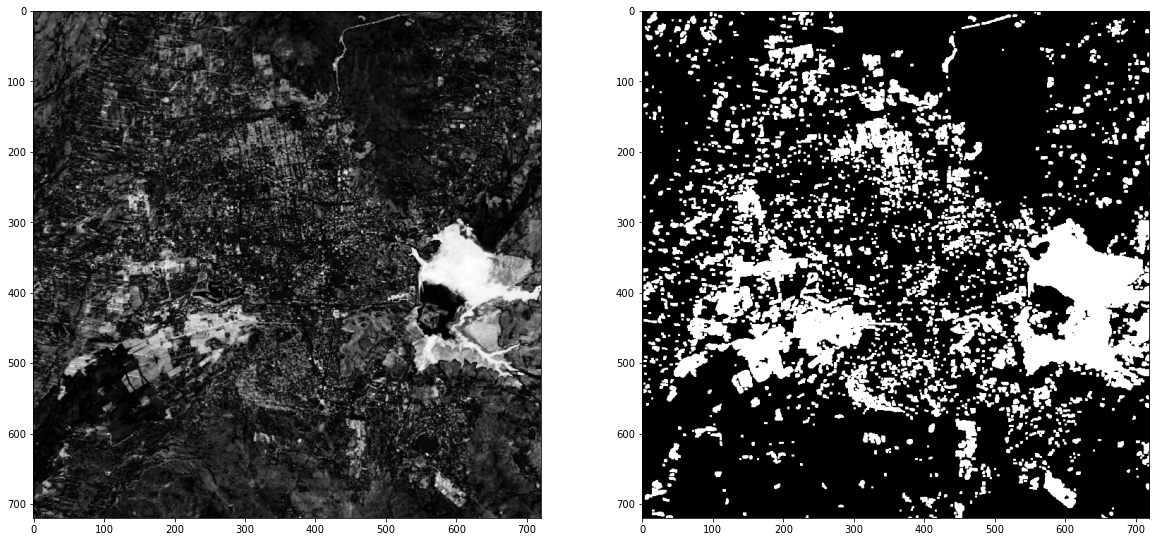

In [290]:
# Crea figura y ejes (en este caso es un arreglo de 3 x 3)
fig=plt.figure(figsize=(20, 30))
# Hace los ejes accesibles con una sola indexación
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(dindv[0],cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(cambio,cmap='gray')

## Bloque de tamaño 5

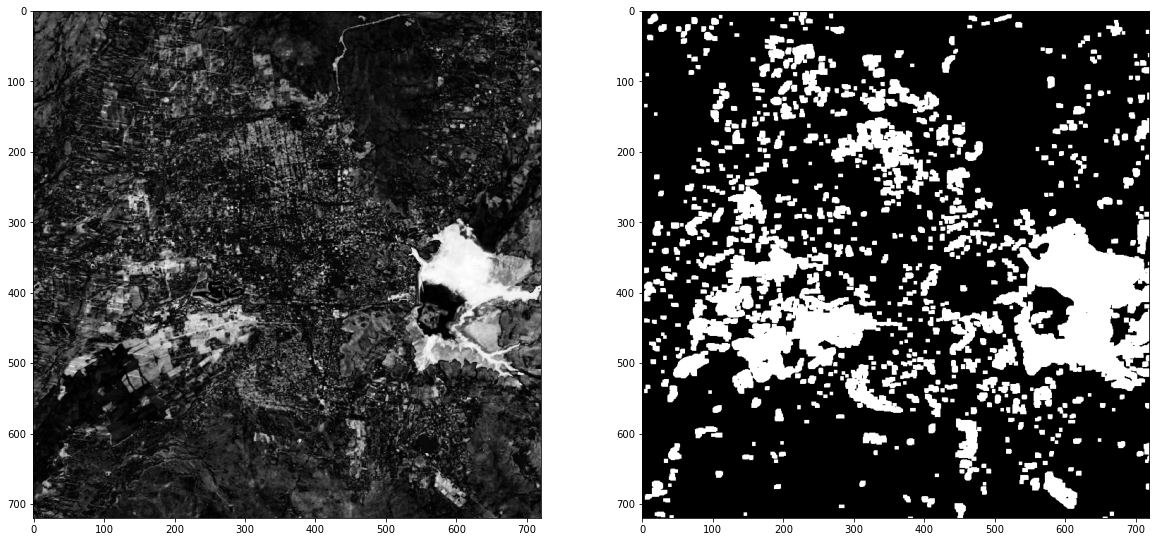

In [296]:
# Crea figura y ejes (en este caso es un arreglo de 3 x 3)
fig=plt.figure(figsize=(20, 30))
# Hace los ejes accesibles con una sola indexación
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(dindv[0],cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(cambio,cmap='gray')

## Bloque de tamaño 9


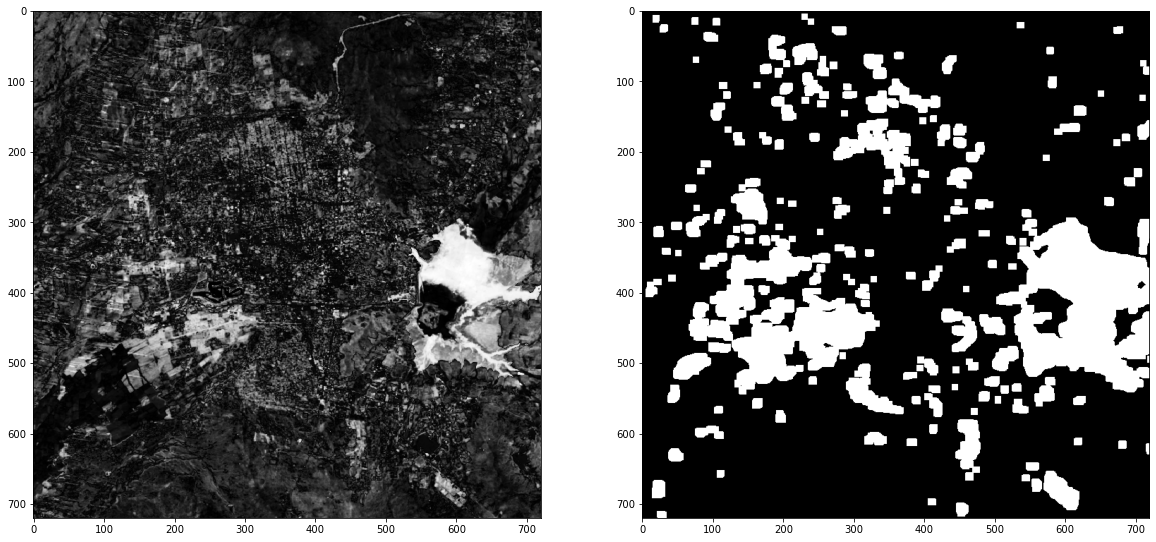

In [281]:
# Crea figura y ejes (en este caso es un arreglo de 3 x 3)
fig=plt.figure(figsize=(20, 30))
# Hace los ejes accesibles con una sola indexación
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(dindv[0],cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(cambio,cmap='gray')